## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import packages
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Section 1. Camera calibration
Find object points and image points

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Section 2. Undistortion to raw images
Calibrate, calculate distortion coefficients, and test undistortion.

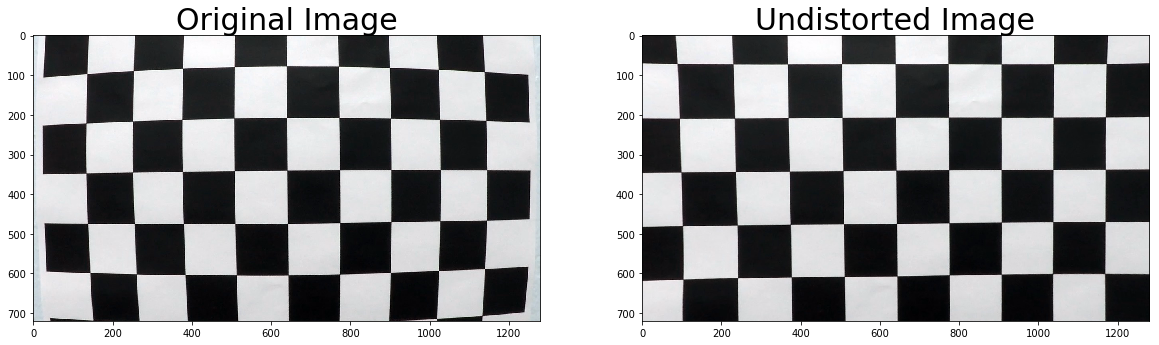

In [4]:
# Undistort the test image
img = cv2.imread('camera_cal/calibration1.jpg')

# Perform calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

#cv2.imwrite('output_images/undistort_calibration1.jpg', dst)

# Save the calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('output_images/undistort_calibration1.jpg')

def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Section 3. Perspective Transform
Transform to bird-eye view

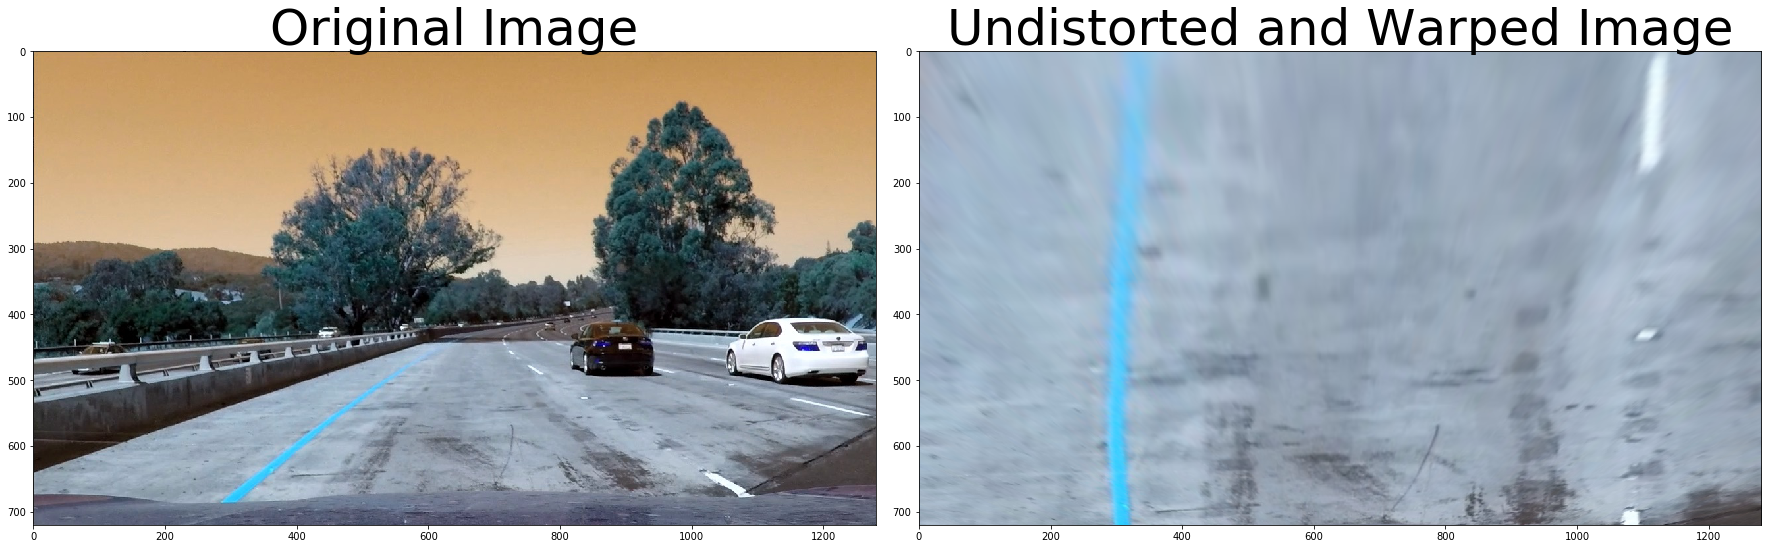

In [7]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_images/test1.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Function for perspective transform
def persp_transform(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
#     cv2.imwrite('output_images/undistort_test1.jpg', undist)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    img_size = (gray.shape[1], gray.shape[0])

    src = np.float32([[581, 477], [699, 477], [896, 675], [384, 675]])
    dst = np.float32([[384, 0], [896, 0], [896, 720], [384, 720]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_rev = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, M_rev

def persp_transform_rev(img, M_rev):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    rev = cv2.warpPerspective(img, M_rev, img_size)
    return rev

top_down, M, M_rev = persp_transform(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
# cv2.imwrite('output_images/top_down_test1.jpg', top_down)

## Section 4. Thresholding
Apply color transoforms and gradiants

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


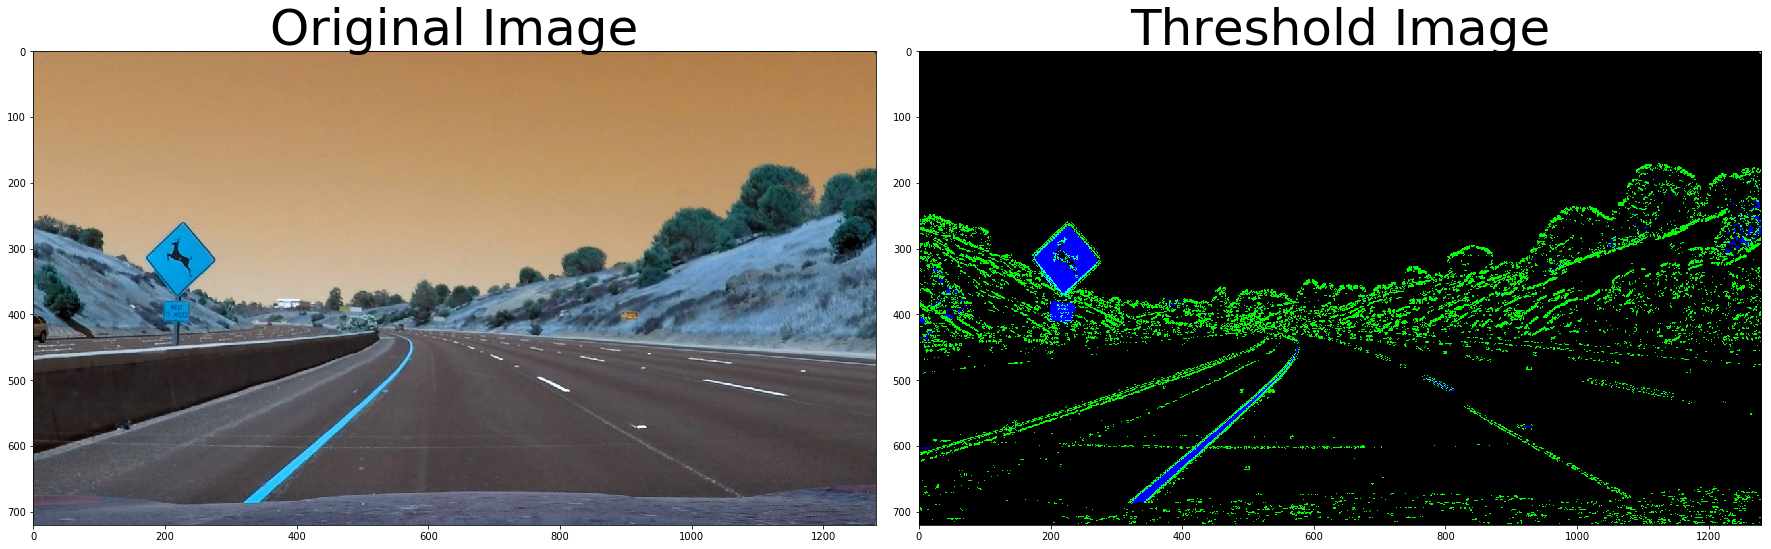

In [9]:
# Apply sobel and use a combination of magnitude and direction thresholding
# The first three helper functions are from Quiz: Combine thresholds
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    direc = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(direc)
    dir_binary[(direc >= thresh[0]) & (direc <= thresh[1])] = 1
    return dir_binary

# Combine sobelx, sobely, magnitde and direction thresholding
def combine_sobel(image, ksize = 15):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.4))
    combined_sobel = np.zeros_like(dir_binary)
    combined_sobel[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_sobel

# Combine color thresholding and sobel
def combine_thresh(img, s_thresh = (170, 255)):
    sobel_output = combine_sobel(img, ksize=15)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack sobel and s_channel
    combine = np.dstack(( np.zeros_like(sobel_output), sobel_output, s_binary)) * 255
    return combine

img = cv2.imread('test_images/test2.jpg')
img_thresh = combine_thresh(img, s_thresh = (200, 255))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_thresh)
ax2.set_title('Threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
# cv2.imwrite('output_images/threshold_test1.jpg', img_thresh)

## Section 5. Combine sections 1~4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape = (720, 1280, 3)


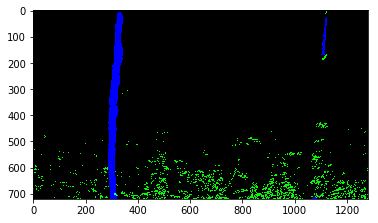

In [13]:
def prepare(img):
    # Undistort the image
    undist = undistort(img)
    # Carry out perspective transform
    topdown, M, M_rev = persp_transform(undist, nx, ny, mtx, dist)
    # Apply thresholding
    binary_warped = combine_thresh(topdown)
    return binary_warped, M, M_rev

img = cv2.imread('test_images/test1.jpg')
binary_warped, M, M_rev = prepare(img)
print("image shape = {}".format(binary_warped.shape))
# binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
cv2.imwrite('test_images/TEST.jpg', binary_warped)
plt.imshow(binary_warped)
plt.show()

## Section 6. Sliding windows

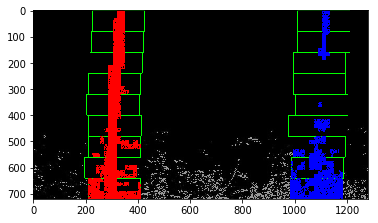

In [19]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty

img = cv2.imread('test_images/TEST.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# print("image shape = {}".format(img.shape))
img_fit, left_fit, right_fit, ploty = fit_polynomial(img)
plt.imshow(img_fit)
plt.show()
# cv2.imwrite('output_images/sliding_windows_test1.jpg', img_fit)

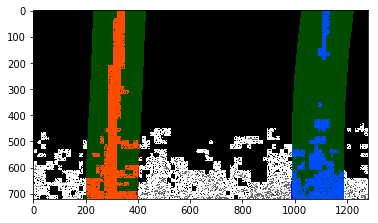

In [21]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty

img = cv2.imread('test_images/TEST.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
result, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = search_around_poly(img)
plt.imshow(result)
plt.show()
# cv2.imwrite('output_images/search_from_prior_test1.jpg', result)

## Section 7: Lane Curvature and vehicle position

In [23]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def curvature_and_position(img, leftx, lefty, rightx, righty, ploty):
    ## Find radius of curvature ##
    # Find polyfit in unit of meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of radius of curvature
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**(3/2)/(2*abs(left_fit_cr[0]))  
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**(3/2)/(2*abs(right_fit_cr[0]))
    
    ## Find car position relative to the center of road ##
    center = img.shape[1]/2*xm_per_pix
    y_max = img.shape[0]*ym_per_pix
    l_bound = left_fit_cr[0]*y_max**2 + left_fit_cr[1]*y_max + left_fit_cr[2]
    r_bound = right_fit_cr[0]*y_max**2 + right_fit_cr[1]*y_max + right_fit_cr[2]
    width = r_bound - l_bound
    position = (center - (l_bound + width/2))
    return left_curverad, right_curverad, position

left_curverad, right_curverad, position = curvature_and_position(img, leftx, lefty, rightx, righty, ploty)
print(left_curverad, right_curverad, position)



9798.481917357438 1318.4295338662703 -0.28668429071885626


## Section 8: Display effects on orinal image

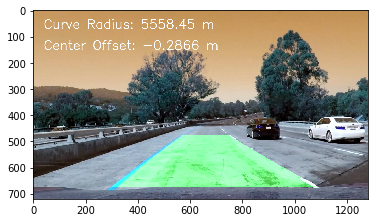

In [24]:
def display(img, binary_warped, left_fitx, right_fitx, ploty, M_rev):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    warp_zero = cv2.cvtColor(warp_zero, cv2.COLOR_BGR2GRAY)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #print("image shape = {}".format(color_warp.shape))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw lane lines
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Transform the image back to camera view
    lines_warpback = persp_transform_rev(color_warp, M_rev)
    # Stack original image and lane lines
    combined = cv2.addWeighted(img, 1, lines_warpback, 0.5, 0) 
    return combined

def label(combined, left_curverad, right_curverad, position):
    cv2.putText(combined,'Curve Radius: '+str((left_curverad + right_curverad)/2)[:7]+\
                ' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(combined,'Center Offset: '+str(position)[:7]+\
                ' m',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    return combined

img = cv2.imread('test_images/test1.jpg')
output = display(img, binary_warped, left_fitx, right_fitx, ploty, M_rev)
output_labeled = label(output, left_curverad, right_curverad, position)
cv2.imwrite('output_images/test1.jpg', output_labeled)
plt.imshow(output_labeled)
plt.show()

## Section 9. Construct pipeline and test on images

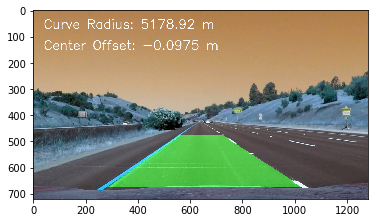

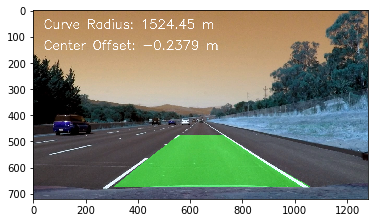

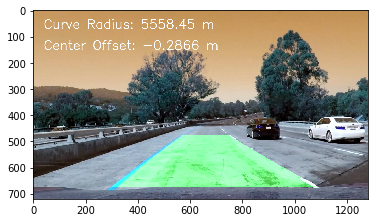

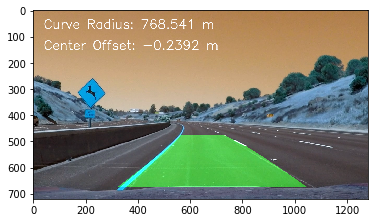

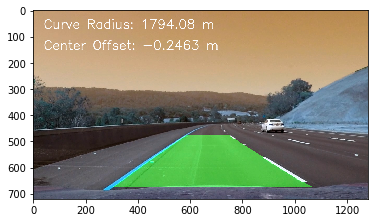

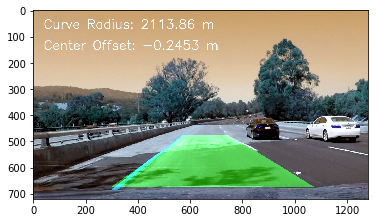

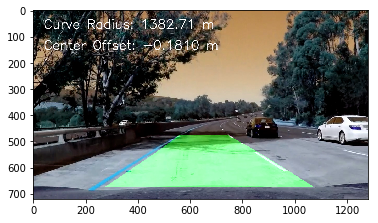

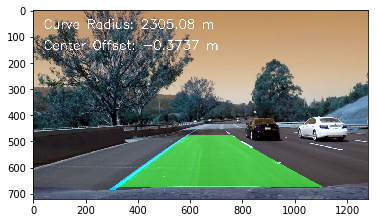

In [25]:
def annotate(img):
    # Combine above steps to annotate images
    binary_warped, M, M_rev = prepare(img)
    cv2.imwrite('test_images/temp.jpg', binary_warped)
    binary_warped = cv2.imread('test_images/temp.jpg')
    gray = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    img_fit, left_fit, right_fit, ploty = fit_polynomial(gray)
    result, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = search_around_poly(gray)
    left_curverad, right_curverad, position = curvature_and_position(gray, leftx, lefty, rightx, righty, ploty)

    output = display(img, binary_warped, left_fitx, right_fitx, ploty, M_rev)
    output_labeled = label(output, left_curverad, right_curverad, position)
    return output_labeled

# Create a list of test images
list = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', \
        'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
# Find the length of the list
length = len(list)

def pipeline(directory):
    image = cv2.imread(directory)
    output = annotate(image)
    #cv2.imwrite('output_images/' + list[i], output)
    plt.figure()
    plt.imshow(output)
    
for i in range(length):
    #print(i)
    pipeline('test_images/' + list[i])
    

## Section 10. Test on video

In [12]:
def process_image(image):
    # return the final output (image where lines are drawn on lanes)
    output = annotate(image)
    return output

In [15]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [15:21<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 19min 9s, sys: 1min 43s, total: 20min 52s
Wall time: 15min 22s


In [16]:
# Display the output of project video 
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [21]:
white_output_2 = 'output_images/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
white_clip_2 = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip_2.write_videofile(white_output_2, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [05:30<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 6min 41s, sys: 37.5 s, total: 7min 18s
Wall time: 5min 32s


In [22]:
# Display the output of challenge video 
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_2))